In [96]:
# Import necessary packages
import os
import sys
import random
import warnings
import math
import re
from tqdm import tqdm
from itertools import chain

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.nn import TransformerEncoderLayer, TransformerEncoder

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Set parameters
BATCH_SIZE = 1
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3

TRAIN_PATH = '../data/sample_data/40x_magnification'
TEST_PATH = '../data/sample_data/40x_magnification'

print("TRAIN_PATH exists:", os.path.exists(TRAIN_PATH))
print("TEST_PATH exists:", os.path.exists(TEST_PATH))
print(TRAIN_PATH)

TRAIN_PATH exists: True
TEST_PATH exists: True
../data/sample_data/40x_magnification


In [97]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
num_test_items = int(0.1 * len(train_ids))

# Slice the train_ids list to get the test IDs
test_ids = train_ids[-num_test_items:]


In [98]:
sequences = {}
masks = {}
time_steps_list = []

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
Y_train_1 = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
Y_train_2 = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = os.path.join(TRAIN_PATH, id_)
    
    # Extract time step 
    match = re.search(r'_i(\d+)_', id_)
    if match:
        time_step = int(match.group(1))
    else:
        raise ValueError(f"Time step not found in the filename: {id_}")
    time_steps_list.append(time_step)
    
    img_path = os.path.join(path, 'images', id_ + '_mSLIM' + '.png')
    img = imread(img_path)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    img = np.expand_dims(img, axis=-1).astype(np.float64)
    X_train[n] = img.astype(np.float64)
    
    # Load masks
    for mask_file in next(os.walk(os.path.join(path, 'masks/')))[2]:
        mask = imread(os.path.join(path, 'masks', mask_file))
        mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        if mask_file.endswith('Prot.png'):
            Y_train_2[n] = np.where(mask[:, :, np.newaxis] > 0, 2, 0)
        else:
            Y_train_1[n] = np.where(mask[:, :, np.newaxis] > 0, 1, 0)

    Y_train[n] = np.maximum(Y_train_1[n], Y_train_2[n])
    
    if time_step not in sequences:
        sequences[time_step] = []
        masks[time_step] = []
    sequences[time_step].append(X_train[n])
    masks[time_step].append(Y_train[n])

# Sort sequences by time steps
time_steps = sorted(sequences.keys())
X_sequences = [np.stack(sequences[t]) for t in time_steps]
Y_sequences = [np.stack(masks[t]) for t in time_steps]

X_sequences = np.array(X_sequences)  
Y_sequences = np.array(Y_sequences)

print('Data loaded and resized.')

Getting and resizing train images and masks ... 


100%|██████████| 6/6 [00:02<00:00,  2.18it/s]

Data loaded and resized.


In [99]:
split_ratio = 0.8
split_idx = int(X_train.shape[0] * split_ratio)

x = X_train[:split_idx]
y = Y_train[:split_idx]
x_val = X_train[split_idx:]
y_val = Y_train[split_idx:]

test_ratio = 0.5
split_test = int(x_val.shape[0] * test_ratio)

X_test = x_val[split_test:]
Y_test = y_val[split_test:]
x_val = x_val[:split_test]
y_val = y_val[:split_test]

x_train_tensor = torch.from_numpy(x).float()
y_train_tensor = torch.from_numpy(y).float()

x_val_tensor = torch.from_numpy(x_val).float()
y_val_tensor = torch.from_numpy(y_val).float()

x_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(Y_test).float()

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)


In [100]:
def show_mask(mask, title=None):
    cmap = plt.cm.colors.ListedColormap(['black', 'green', 'yellow'])  
    bounds = [-0.5, 0.5, 1.5, 2.5]  
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(mask, cmap=cmap, norm=norm)
    cbar = plt.colorbar(ticks=[0, 1, 2])
    cbar.ax.set_yticklabels(['Background', 'Live', 'Dead'])
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

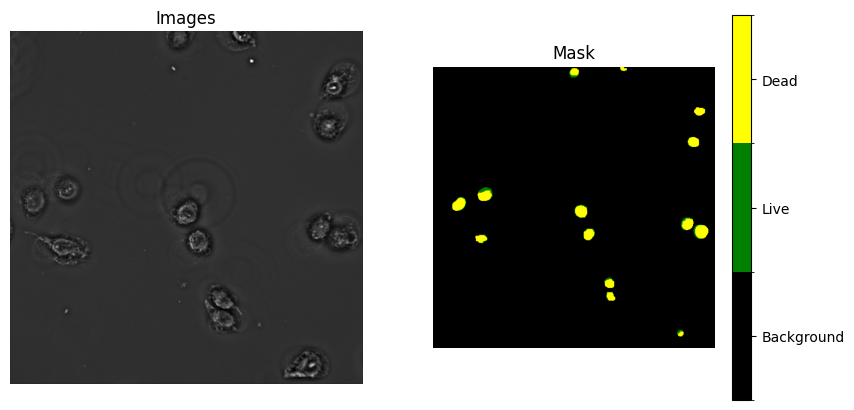

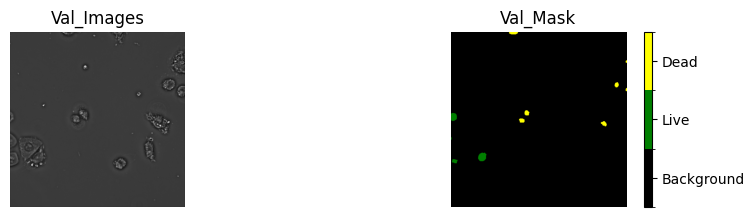

In [101]:

import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(x[0,:,:,0], cmap='gray')
plt.title("Images")
plt.axis('off')

plt.subplot(1, 2, 2)
show_mask(y[0],"Mask")

plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 1)
plt.imshow(x_val[0,:,:,0], cmap='gray')
plt.title("Val_Images")
plt.axis('off')

plt.subplot(2, 2, 2)
show_mask(y_val[0],"Val_Mask")
#creating a training and validation generator that generate masks and images
#train_generator = zip(x, y)
#val_generator = zip(x_val, y_val)


In [102]:
# Define IoU metric
import torch

def mean_iou(y_pred, y_true, num_classes=3):
    
    y_pred = torch.argmax(y_pred, dim=1)

    iou_list = []
    
    for class_id in range(num_classes):
       
        intersection = torch.sum((y_true == class_id) & (y_pred == class_id))
        union = torch.sum((y_true == class_id) | (y_pred == class_id))
        
        
        if union == 0:
            iou = torch.tensor(1.0)
        else:
            iou = intersection.float() / union.float()
        
        iou_list.append(iou)

    return torch.mean(torch.tensor(iou_list))




In [103]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super(ConvBlock, self).__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.conv_block(x))
        else:
            return self.conv_block(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(DownSample, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, in_channels, residual=True),
            ConvBlock(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x):
        x = self.maxpool_conv(x)
        return x

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(UpSample, self).__init__()

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.out_channels = out_channels
        self.conv = nn.Sequential(
            ConvBlock(in_channels, in_channels, residual=True),
            ConvBlock(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, skip_x):

        x = self.upsample(x)
        #print(x.shape)
        #print(skip_x.shape)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        #emb = self.emb_layer(t)[:, :, None, None].expand(-1, -1, x.shape[-2], x.shape[-1])
        return x

class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3):
        super(UNet, self).__init__()
        self.initial_conv = ConvBlock(c_in, 64)
        self.downsample1 = DownSample(64, 128)
        self.self_attention1 = SelfAttention(128, 128)
        self.downsample2 = DownSample(128, 256)
        self.self_attention2 = SelfAttention(256, 256)
        self.downsample3 = DownSample(256, 256)
        self.self_attention3 = SelfAttention(256, 256)

        self.bottom1 = ConvBlock(256, 512)
        self.bottom2 = ConvBlock(512, 512)
        self.bottom3 = ConvBlock(512, 256)

        self.upsample1 = UpSample(512, 128)
        self.self_attention4 = SelfAttention(128, 128)
        self.upsample2 = UpSample(256, 64)
        self.self_attention5 = SelfAttention(64, 64)
        self.upsample3 = UpSample(128, 64)
        self.self_attention6 = SelfAttention(64, 64)
        self.output_conv = nn.Conv2d(64, c_out, kernel_size=1)

    def forward(self, x):

        x1 = self.initial_conv(x)
        x2 = self.downsample1(x1)
        #x2 = self.self_attention1(x2)
        x3 = self.downsample2(x2)
        #x3 = self.self_attention2(x3)
        x4 = self.downsample3(x3)
        #x4 = self.self_attention3(x4)

        x4 = self.bottom1(x4)
        x4 = self.bottom2(x4)
        x4 = self.bottom3(x4)

        x = self.upsample1(x4, x3)
        #x = self.self_attention4(x)
        x = self.upsample2(x, x2)
        #x = self.self_attention5(x)
        x = self.upsample3(x, x1)
        #x = self.self_attention6(x)
        output = self.output_conv(x)
        return output

In [104]:
#define early stopping
class EarlyStopping:
    def __init__(self, patience=3, verbose=True, name="null"):
        self.patience = patience
        self.verbose = verbose
        self.name = name
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0
        return self.early_stop

    def save_checkpoint(self, model):
        if self.verbose:
            print(f'Saving model...')
        torch.save(model.state_dict(), f'checkpoint_{self.name}.pth')


In [105]:
import torch.backends.cudnn as cudnn

c_in = 3  # input channel 3 for RGB
c_out = 3  # output channel
if torch.cuda.device_count() >= 1:
    device1 = torch.device("cuda:0")
    device2 = torch.device("cuda:1")
else:
    raise RuntimeError("Multiple GPUs are required.")

model = UNet(c_in, c_out)
checkpoint = torch.load('../weights/checkpoint.pth')
modified_state_dict = {key.replace('module.', ''): value for key, value in checkpoint.items()}
model.load_state_dict(modified_state_dict)
cudnn.benchmark = True
model = torch.nn.DataParallel(model)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=5, verbose=True, name="unet")
scheduler =  torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

In [106]:

# Training loop

#If want to re-train the model, uncomment the code below


# num_epochs = 100
# model.to(device1)
# best_loss = 1.0
# best_iou = 0.0
# log_file = open("training_log_unet_cell14_trial2.txt", "w")
# for epoch in range(0,num_epochs):
#     model.train()
#     total_loss = 0.0
#     total_iou = 0.0
#     for i,(inputs, labels) in enumerate(tqdm(train_loader)):
#         gpu = torch.cuda.get_device_properties(device1)
#         #print(f'{device1}: {gpu.name}, Total Memory: {gpu.total_memory / 1024**2:.2f} MB, Free Memory: {torch.cuda.max_memory_allocated(device1) / 1024**2:.2f} MB')
#         #print(torch.cuda.memory_allocated(device1))
#         #print(torch.cuda.max_memory_allocated(device1))
#         if torch.cuda.memory_allocated(device1) > 0.9 * gpu.total_memory:
#             model = model.to(device2)
#             device1, device2 = device2, device1
#             print('changed gpu')
#             #inputs, labels = inputs.to(device1), labels.to(device1)
#             model = model.to(device1)
            
#         inputs, labels = inputs.permute(0, 3, 1, 2).to(device1), labels.permute(0, 3, 1, 2).to(device1)
#         #print(inputs.shape)
#         #print(labels.shape)
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         labels = labels.squeeze(1)
#         iou = mean_iou(outputs, labels)
#         labels = labels.long()
#         # print(f"Min label value: {labels.min()}, Max label value: {labels.max()}")

#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#         total_iou += iou.item()

#         if i % 50 == 0 and i != 0:
#             print(f"Epoch {epoch+1}: Batch[{i}/{len(train_loader)}] Loss: {total_loss / i} IoU: {total_iou / i}")
#             if i % 100 == 0:
#                 print(f'Saving model...')
#                 torch.save(model.state_dict(), 'checkpoint_unet.pth')
#     avg_loss = total_loss / len(train_loader)
#     avg_iou = total_iou / len(train_loader)
#     print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss} IoU: {avg_iou}")

#     best_loss = min(best_loss,avg_loss)
#     best_iou = max(best_iou,avg_iou)

#     log_file.write(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss} IoU: {avg_iou}\n")
#     log_file.write(f'Best loss: {best_loss}, Best IoU: {best_iou}\n\n')
#     log_file.flush()

#     if early_stopping(avg_loss, model):
#         print('Early stopping triggered')
#         break
    
# torch.save(model.state_dict(), 'model.pth')
# print(f'Best loss is {best_loss}, best iou is {best_iou}')


In [107]:
#Calculating Validation Loss and Validation IoU


model = model.to(device1)
model.eval()
total_val_loss = 0.0
total_val_iou = 0.0
num_batches = len(val_loader)

with torch.no_grad():
    for inputs, labels in tqdm(val_loader):
        inputs, labels = inputs.permute(0, 3, 1, 2).to(device1), labels.permute(0, 3, 1, 2).to(device1)
        outputs = model(inputs)
        labels = labels.squeeze(1)
        total_val_iou += mean_iou(outputs, labels).item()
        labels = labels.long()
        loss = criterion(outputs, labels)
        total_val_loss += loss.item()
        
preds_val = outputs

avg_val_loss = total_val_loss / num_batches
avg_val_iou = total_val_iou / num_batches

print(f"Validation Loss: {avg_val_loss}, Validation IoU: {avg_val_iou}")


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

Validation Loss: 0.003045258577913046, Validation IoU: 0.9024279713630676


In [108]:
model = model.to(device1)
model.eval()
# with torch.no_grad():
#     for inputs in tqdm(val_loader):
#         inputs = inputs[0].permute(0, 3, 1, 2).to(device2)
#         outputs = model(inputs)
        #print(outputs.shape)
#torch.save(model.state_dict(),'cell_segment.pth')
#prediction
#X_train = torch.Tensor(X_train).permute(0, 3, 1, 2).to(device)
#model=model.to(device1)
preds_val=[]
preds_test=[]

# X_test = torch.Tensor(X_test).permute(0, 3, 1, 2)
# val_X = x_val_tensor.permute(0,3,1,2)
X_test_tensor = torch.tensor(X_test).permute(0, 3, 1, 2)
test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

with torch.no_grad():
    #preds_train = model(X_train[:int(X_train.shape[0]*0.9)])
    #preds_val = model(X_train[int(X_train.shape[0]*0.9):])
    #preds_train = model(x_train_tensor.permute(0,3,1,2).to(device2))
    # preds_val = model(val_X[:int(val_X.shape[0]*0.06)].to(device2))
    # preds_test = model(X_test[:int(X_test.shape[0]*0.06)].to(device2))
    # preds_val = model(val_X.to(device1))
    # preds_test = model(X_test.to(device1))
    for inputs, labels in tqdm(val_loader):
        inputs, labels = inputs.permute(0, 3, 1, 2).to(device1), labels.permute(0, 3, 1, 2).to(device1)
        outputs = model(inputs)
        preds_val.append(outputs)

    for batch in tqdm(test_loader):
        inputs = batch[0].to(device1).float()
        outputs = model(inputs)
        preds_test.append(outputs)
        

#print(preds_test[0].size())
# # Threshold predictions
# threshold = 0.5
# #preds_train_t = (preds_train > threshold).byte()
# preds_val_t = (preds_val > threshold)
# preds_test_t = (preds_test > threshold)

# # Create a list of upsampled test masks
# preds_test_upsampled = []
# for i in range(len(preds_test)):
#     preds_test_upsampled.append(np.squeeze(preds_test_t[i]))
    


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


In [109]:
def transform(preds):
    
    preds_val_transformed = []
    
    for pre in preds:
        preds_argmax = torch.argmax(pre, dim=1)
        #print(preds_argmax.shape)
        preds_val_transformed.append(preds_argmax)
        
    preds = torch.cat(preds_val_transformed, dim=0)
    
    return preds

In [110]:
preds_val_t = transform(preds_val)
preds_test_t = transform(preds_test)

In [111]:
print(preds_val_t.shape)

torch.Size([1, 512, 512])


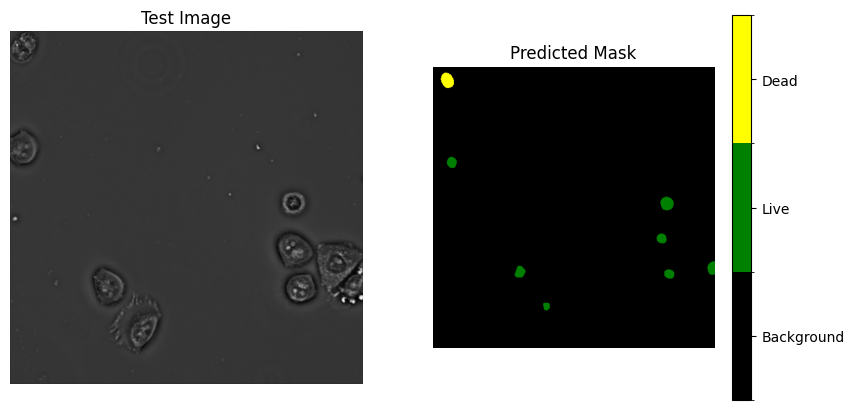

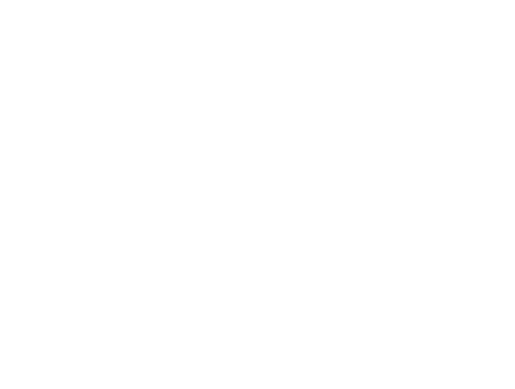

In [112]:
random_index = random.randint(0, len(preds_test_t) - 1)
test_image = X_test[random_index,:, :, 0]
predicted_mask = preds_test_t[random_index].cpu().numpy()
# predicted_mask_1 = preds_test_t[random_index][0].cpu().numpy()
# predicted_mask_2 = preds_test_t[random_index][1].cpu().numpy()

# predicted_mask = np.zeros_like(predicted_mask_1,dtype=np.uint8)
# predicted_mask[predicted_mask_1>0] = [255,255,0]
# predicted_mask[predicted_mask_2>0] = [128,0,128]

#predicted_mask = np.transpose(predicted_mask, (1, 2, 0))

# print(test_image.shape)
# print(predicted_mask.shape)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
#plt.imshow(test_image, cmap='gray')
plt.imshow(test_image, cmap='gray')
plt.title("Test Image")
plt.axis('off')

plt.subplot(1, 2, 2)
# plt.imshow(predicted_mask)
# plt.title("Predicted Mask")
# print(preds_test_t.shape)

# if predicted_mask.ndim == 1:
#     predicted_mask = predicted_mask.reshape(128, 128)
show_mask(predicted_mask,"Predicted Mask")
plt.axis('off')

plt.show()

In [113]:
for i in range(len(preds_test_t)):
    predicted_mask = preds_test_t[i].cpu().numpy()
    #predicted_mask = np.transpose(predicted_mask, (1, 2, 0))

    cmap = plt.cm.colors.ListedColormap(['black', 'green', 'yellow'])  
    bounds = [-0.5, 0.5, 1.5, 2.5]  
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(predicted_mask, cmap=cmap, norm=norm)
    cbar = plt.colorbar(ticks=[0, 1, 2]) 
    cbar.ax.set_yticklabels(['Background', 'Live', 'Dead'])
    plt.axis('off')
    
    mask_name = os.path.join('../data/result/test', f'predicted_mask_{i}.jpg')
    image_name = os.path.join('../data/result/test', f'image_{i}.jpg')
    #print(mask_name)
    plt.savefig(mask_name) 
    plt.close()  

    plt.imshow(X_test[i,:, :, 0], cmap='gray')
    plt.axis('off')
    plt.savefig(image_name)  
    plt.close() 

In [114]:
import random
import torch
import matplotlib.pyplot as plt

# Define a function to display images
def imshow_tensor(tensor):
    # Ensure the tensor is on the CPU and convert it to a NumPy array
    #tensor = tensor.cpu().numpy()

    # If the tensor is 3D (C, H, W) and has a single channel, squeeze it to (H, W)
    if len(tensor.shape) == 3 and tensor.shape[0] == 1:
        tensor = tensor.squeeze(0)
    
    if tensor.shape[0] == 3:
        tensor = np.transpose(tensor, (1, 2, 0))

    # Display the image
    plt.imshow(tensor, cmap='gray')
    plt.show()


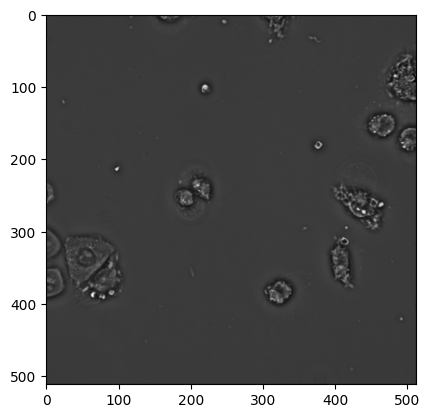

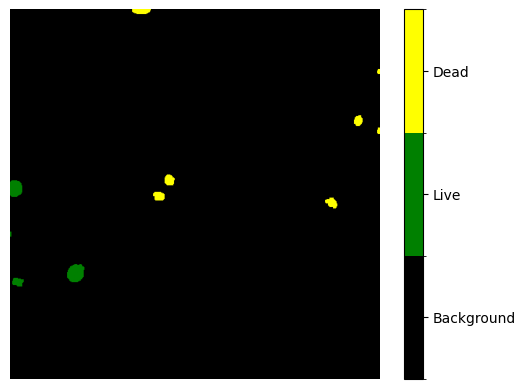

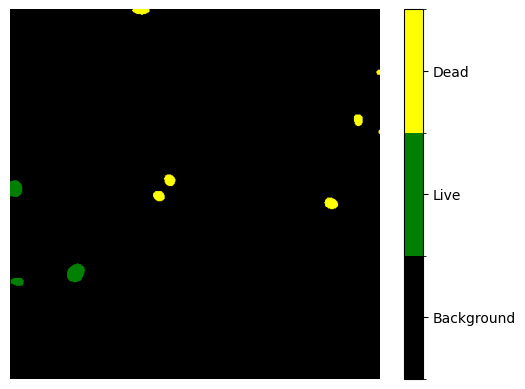

In [115]:
X_val_cpu = x_val
Y_val_cpu = y_val

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_val_t)-1)
predicted_val_mask = preds_val_t[ix].cpu().numpy()
#predicted_val_mask = np.transpose(predicted_val_mask,(1,2,0))

imshow_tensor(X_val_cpu[ix,:,:,0])
#imshow_tensor(Y_val_cpu[ix])
show_mask(Y_val_cpu[ix])
#imshow_tensor(np.squeeze(preds_val[ix]).cpu().astype(np.float32) / 255.0)
show_mask(predicted_val_mask)

In [116]:
import cv2

for i in range(len(preds_val_t)):
    predicted_mask = preds_val_t[i].cpu().numpy()
    #predicted_mask = np.transpose(predicted_mask, (1, 2, 0))
    
    ground_show = Y_val_cpu[i,:,:,0]

    mask_name = os.path.join('../data/result/val', f'predicted_mask_{i}.jpg')
    image_name = os.path.join('../data/result/val', f'image_{i}.jpg')
    ground_name = os.path.join('../data/result/val', f'ground_truth_{i}.jpg')

    cmap = plt.cm.colors.ListedColormap(['black', 'green', 'yellow'])  
    bounds = [-0.5, 0.5, 1.5, 2.5]  
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(predicted_mask, cmap=cmap, norm=norm)
    cbar = plt.colorbar(ticks=[0, 1, 2]) 
    cbar.ax.set_yticklabels(['Background', 'Live', 'Dead'])
    plt.axis('off')
    
    plt.savefig(mask_name)
    plt.close()

    plt.imshow(X_val_cpu[i, :, :, 0], cmap='gray')
    plt.axis('off')
    plt.savefig(image_name)
    plt.close()

    cmap = plt.cm.colors.ListedColormap(['black', 'green', 'yellow'])  
    bounds = [-0.5, 0.5, 1.5, 2.5]  
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(ground_show, cmap=cmap, norm=norm)
    cbar = plt.colorbar(ticks=[0, 1, 2]) 
    cbar.ax.set_yticklabels(['Background', 'Live', 'Dead'])
    plt.axis('off')
    plt.savefig(ground_name)
    plt.close()

In [117]:
all_X = np.concatenate([x, x_val, X_test], axis=0)
all_Y = np.concatenate([y, y_val, Y_test], axis=0)
all_time_steps = []

train_time_steps = time_steps_list[:len(x)]
val_time_steps = time_steps_list[len(x):len(x) + len(x_val)]
test_time_steps = time_steps_list[len(x) + len(x_val):]

all_time_steps = train_time_steps + val_time_steps + test_time_steps

print(f"Length of reconstructed all_time_steps: {len(all_time_steps)}") 

# Create a DataLoader for all data
all_X_tensor = torch.from_numpy(all_X).float()
all_Y_tensor = torch.from_numpy(all_Y).float()
all_dataset = TensorDataset(all_X_tensor, all_Y_tensor)
all_loader = DataLoader(all_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Get predictions
model.to(device1)
model.eval()
preds_all = []
with torch.no_grad():
    for inputs, _ in tqdm(all_loader):
        inputs = inputs.permute(0, 3, 1, 2).to(device1)
        outputs = model(inputs)
        preds_all.append(outputs.cpu())


Length of reconstructed all_time_steps: 6


100%|██████████| 6/6 [00:01<00:00,  4.06it/s]


In [118]:

# Transform predictions
preds_all_t = transform(preds_all)

In [119]:

data_df = pd.DataFrame({
    'image': list(all_X),
    'mask': list(all_Y),
    'time_step': all_time_steps,
    'predicted_mask': list(preds_all_t)
})

data_df = data_df.sort_values('time_step').reset_index(drop=True)


seq_length = 4  

input_sequences = []
target_sequences = []

for i in range(len(data_df) - seq_length):
    input_seq = np.stack(data_df['predicted_mask'].iloc[i:i+seq_length].values)
    target_seq = data_df['predicted_mask'].iloc[i+seq_length]
    input_sequences.append(input_seq)
    target_sequences.append(target_seq)

input_sequences = np.array(input_sequences)  
target_sequences = np.array(target_sequences)  


In [120]:
print(f"Number of input sequences: {len(input_sequences)}")
print(f"Number of target sequences: {len(target_sequences)}")


Number of input sequences: 2
Number of target sequences: 2


In [121]:
# Flatten the masks
input_sequences_flat = input_sequences.reshape(-1, seq_length, IMG_HEIGHT * IMG_WIDTH)
target_sequences_flat = target_sequences.reshape(-1, IMG_HEIGHT * IMG_WIDTH)

# Convert to tensors
input_sequences_tensor = torch.tensor(input_sequences_flat, dtype=torch.float32)
target_sequences_tensor = torch.tensor(target_sequences_flat, dtype=torch.long)  # Use long for CrossEntropyLoss

# Split into train and validation sets
split_idx = int(len(input_sequences_tensor) * split_ratio)
input_sequences_train_tensor = input_sequences_tensor[:split_idx]
target_sequences_train_tensor = target_sequences_tensor[:split_idx]
input_sequences_val_tensor = input_sequences_tensor[split_idx:]
target_sequences_val_tensor = target_sequences_tensor[split_idx:]

# Create datasets and loaders
train_dataset = TensorDataset(input_sequences_train_tensor, target_sequences_train_tensor)
val_dataset = TensorDataset(input_sequences_val_tensor, target_sequences_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [122]:
class Informer(nn.Module):
    def __init__(self, img_height=IMG_HEIGHT, img_width=IMG_WIDTH, embed_dim=64, num_heads=4, num_layers=2, dropout=0.1):
        super(Informer, self).__init__()
        input_dim = img_height * img_width  # 512 * 512 = 262144
        self.embed = nn.Linear(input_dim, embed_dim)
        encoder_layer = TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(embed_dim, input_dim)
        print(self.decoder)

    def forward(self, src):
        batch_size, seq_length, flattened_dim = src.size()
        src = self.embed(src)  
        src = src.permute(1, 0, 2)  
        output = self.transformer_encoder(src)
        output = output[-1]  
        output = self.decoder(output)
        return output.view(batch_size, -1)  


In [123]:
#Loads a pre-trained informer model from the checkpoint,wraps it into 

informer = Informer(embed_dim=64, num_heads=4, num_layers=2, dropout=0.1)
cudnn.benchmark = True

checkpoint_informer = torch.load('../weights/checkpoint_informer.pth')
modified_state_dict_informer = {key.replace('module.', ''): value for key, value in checkpoint_informer.items()}
informer.load_state_dict(modified_state_dict_informer)

informer = torch.nn.DataParallel(informer)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(informer.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
early_stopping = EarlyStopping(patience=5, verbose=True, name="informer")


c:\Users\austi\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Linear(in_features=64, out_features=262144, bias=True)


In [124]:
def compute_iou(preds, labels, num_classes=3):

    # Get the predicted class for each pixel
    preds = torch.argmax(preds, dim=1)  # Shape: [batch_size, H, W]
    
    iou_list = []
    for cls in range(num_classes):
        intersection = ((preds == cls) & (labels == cls)).sum().item()
        union = ((preds == cls) | (labels == cls)).sum().item()
        if union == 0:
            iou = float('nan')  # If there is no ground truth or prediction for this class
        else:
            iou = intersection / union
        iou_list.append(iou)
    
    # Filter out NaN values and compute the mean IoU
    iou_list = [iou for iou in iou_list if not np.isnan(iou)]
    if len(iou_list) == 0:
        return 0.0
    mean_iou = sum(iou_list) / len(iou_list)
    return mean_iou

In [ ]:

#Below is for training the Informer Model, uncomment if you want to train from scratch




# num_epochs = 100
# informer.to(device1)
# best_loss = float('inf')
# best_iou = 0.0
# log_file = open("training_log_informer_cell14_image_prediction.txt", "w")

# for epoch in range(num_epochs):
#     informer.train()
#     total_loss = 0.0
#     total_iou = 0.0
#     for inputs, labels in tqdm(train_loader):
#         inputs, labels = inputs.to(device1), labels.to(device1)
#         optimizer.zero_grad()
#         outputs = informer(inputs)
             
#         batch_iou = compute_iou(outputs, labels, num_classes=3)
#         total_iou += batch_iou
        
#         outputs = outputs.float()
#         labels = labels.float()
        
#         loss = criterion(outputs, labels)
#         loss.backward()
        
#         optimizer.step()
#         total_loss += loss.item()
        
   

#     avg_loss = total_loss / len(train_loader)
#     avg_iou = total_iou / len(train_loader)
#     print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f} IoU: {avg_iou:.4f}")

#     log_file.write(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f} IoU: {avg_iou:.4f}\n")
#     log_file.flush()

#     # Update best metrics and save model
#     if avg_iou > best_iou:
#         best_iou = avg_iou
#         torch.save(informer.state_dict(), 'best_informer_model.pth')

#     # Early stopping
#     if early_stopping(avg_loss, informer):
#         print('Early stopping triggered')
#         break

# print(f'Best Loss: {best_loss:.4f}, Best IoU: {best_iou:.4f}')


100%|██████████| 20/20 [00:01<00:00, 15.62it/s]


Epoch [1/100] Loss: 3074.4056 IoU: 0.0000
Saving model...


100%|██████████| 20/20 [00:01<00:00, 14.51it/s]


Epoch [2/100] Loss: 2540.1313 IoU: 0.0000
Saving model...


100%|██████████| 20/20 [00:01<00:00, 15.51it/s]


Epoch [3/100] Loss: 1969.5194 IoU: 0.0000
Saving model...


100%|██████████| 20/20 [00:01<00:00, 15.77it/s]


Epoch [4/100] Loss: 1645.4984 IoU: 0.0000
Saving model...


100%|██████████| 20/20 [00:01<00:00, 15.85it/s]


Epoch [5/100] Loss: 1548.6309 IoU: 0.0000
Saving model...


100%|██████████| 20/20 [00:01<00:00, 15.64it/s]


Epoch [6/100] Loss: 1519.9769 IoU: 0.0000
Saving model...


100%|██████████| 20/20 [00:01<00:00, 15.84it/s]


Epoch [7/100] Loss: 1504.0203 IoU: 0.0000
Saving model...


100%|██████████| 20/20 [00:01<00:00, 14.55it/s]


Epoch [8/100] Loss: 1487.7439 IoU: 0.0000
Saving model...


100%|██████████| 20/20 [00:01<00:00, 15.17it/s]


Epoch [9/100] Loss: 1471.4985 IoU: 0.0000
Saving model...


100%|██████████| 20/20 [00:01<00:00, 15.73it/s]


Epoch [10/100] Loss: 1462.4019 IoU: 0.0000
Saving model...


100%|██████████| 20/20 [00:01<00:00, 15.82it/s]


Epoch [11/100] Loss: 1451.4155 IoU: 0.0000
Saving model...


100%|██████████| 20/20 [00:01<00:00, 15.54it/s]


Epoch [12/100] Loss: 1442.8646 IoU: 0.0000
Saving model...


100%|██████████| 20/20 [00:01<00:00, 15.72it/s]


Epoch [13/100] Loss: 1439.6164 IoU: 0.0000
Saving model...


100%|██████████| 20/20 [00:01<00:00, 15.83it/s]


Epoch [14/100] Loss: 1443.5210 IoU: 0.0000
EarlyStopping counter: 1 out of 5


100%|██████████| 20/20 [00:01<00:00, 15.22it/s]


Epoch [15/100] Loss: 1443.0921 IoU: 0.0000
EarlyStopping counter: 2 out of 5


100%|██████████| 20/20 [00:01<00:00, 15.30it/s]


Epoch [16/100] Loss: 1437.4503 IoU: 0.0000
Saving model...


100%|██████████| 20/20 [00:01<00:00, 15.82it/s]


Epoch [17/100] Loss: 1435.4551 IoU: 0.0000
Saving model...


100%|██████████| 20/20 [00:01<00:00, 15.48it/s]


Epoch [18/100] Loss: 1437.9256 IoU: 0.0000
EarlyStopping counter: 1 out of 5


100%|██████████| 20/20 [00:01<00:00, 15.23it/s]


Epoch [19/100] Loss: 1425.7683 IoU: 0.0000
Saving model...


100%|██████████| 20/20 [00:01<00:00, 14.90it/s]


Epoch [20/100] Loss: 1422.5654 IoU: 0.0000
Saving model...


100%|██████████| 20/20 [00:01<00:00, 15.81it/s]


Epoch [21/100] Loss: 1423.1750 IoU: 0.0000
EarlyStopping counter: 1 out of 5


100%|██████████| 20/20 [00:01<00:00, 15.52it/s]


Epoch [22/100] Loss: 1419.6909 IoU: 0.0000
Saving model...


100%|██████████| 20/20 [00:01<00:00, 15.85it/s]


Epoch [23/100] Loss: 1419.1675 IoU: 0.0000
Saving model...


100%|██████████| 20/20 [00:01<00:00, 15.85it/s]


Epoch [24/100] Loss: 1421.8835 IoU: 0.0000
EarlyStopping counter: 1 out of 5


100%|██████████| 20/20 [00:01<00:00, 15.75it/s]


Epoch [25/100] Loss: 1424.9148 IoU: 0.0000
EarlyStopping counter: 2 out of 5


100%|██████████| 20/20 [00:01<00:00, 15.01it/s]


Epoch [26/100] Loss: 1436.9446 IoU: 0.0000
EarlyStopping counter: 3 out of 5


100%|██████████| 20/20 [00:01<00:00, 15.58it/s]


Epoch [27/100] Loss: 1425.7953 IoU: 0.0000
EarlyStopping counter: 4 out of 5


100%|██████████| 20/20 [00:01<00:00, 15.52it/s]


Epoch [28/100] Loss: 1416.8229 IoU: 0.0000
Saving model...


100%|██████████| 20/20 [00:01<00:00, 15.60it/s]


Epoch [29/100] Loss: 1414.0452 IoU: 0.0000
Saving model...


100%|██████████| 20/20 [00:01<00:00, 15.88it/s]


Epoch [30/100] Loss: 1412.9370 IoU: 0.0000
Saving model...


100%|██████████| 20/20 [00:01<00:00, 15.67it/s]


Epoch [31/100] Loss: 1412.5498 IoU: 0.0000
Saving model...


100%|██████████| 20/20 [00:01<00:00, 15.56it/s]


Epoch [32/100] Loss: 1411.6164 IoU: 0.0000
Saving model...


100%|██████████| 20/20 [00:01<00:00, 15.56it/s]


Epoch [33/100] Loss: 1410.7961 IoU: 0.0000
Saving model...


100%|██████████| 20/20 [00:01<00:00, 15.90it/s]


Epoch [34/100] Loss: 1411.6219 IoU: 0.0000
EarlyStopping counter: 1 out of 5


100%|██████████| 20/20 [00:01<00:00, 15.91it/s]


Epoch [35/100] Loss: 1410.1485 IoU: 0.0000
Saving model...


100%|██████████| 20/20 [00:01<00:00, 15.86it/s]


Epoch [36/100] Loss: 1408.5302 IoU: 0.0000
Saving model...


100%|██████████| 20/20 [00:01<00:00, 15.86it/s]


Epoch [37/100] Loss: 1408.8397 IoU: 0.0000
EarlyStopping counter: 1 out of 5


100%|██████████| 20/20 [00:01<00:00, 15.90it/s]


Epoch [38/100] Loss: 1407.5197 IoU: 0.0000
Saving model...


100%|██████████| 20/20 [00:01<00:00, 15.71it/s]


Epoch [39/100] Loss: 1408.5718 IoU: 0.0000
EarlyStopping counter: 1 out of 5


100%|██████████| 20/20 [00:01<00:00, 15.74it/s]


Epoch [40/100] Loss: 1407.5851 IoU: 0.0000
EarlyStopping counter: 2 out of 5


100%|██████████| 20/20 [00:01<00:00, 15.88it/s]


Epoch [41/100] Loss: 1411.6838 IoU: 0.0000
EarlyStopping counter: 3 out of 5


100%|██████████| 20/20 [00:01<00:00, 15.88it/s]


Epoch [42/100] Loss: 1407.2418 IoU: 0.0000
Saving model...


100%|██████████| 20/20 [00:01<00:00, 15.79it/s]


Epoch [43/100] Loss: 1407.4264 IoU: 0.0000
EarlyStopping counter: 1 out of 5


100%|██████████| 20/20 [00:01<00:00, 15.88it/s]


Epoch [44/100] Loss: 1410.2847 IoU: 0.0000
EarlyStopping counter: 2 out of 5


100%|██████████| 20/20 [00:01<00:00, 15.88it/s]


Epoch [45/100] Loss: 1409.9801 IoU: 0.0000
EarlyStopping counter: 3 out of 5


100%|██████████| 20/20 [00:01<00:00, 15.90it/s]


Epoch [46/100] Loss: 1413.8107 IoU: 0.0000
EarlyStopping counter: 4 out of 5


100%|██████████| 20/20 [00:01<00:00, 15.91it/s]

Epoch [47/100] Loss: 1408.9653 IoU: 0.0000
EarlyStopping counter: 5 out of 5
Early stopping triggered
Best Loss: inf, Best IoU: 0.0000


In [125]:
informer.eval()
total_val_loss = 0.0
num_batches = len(val_loader)
all_inputs, all_predictions, all_labels = [], [], []

with torch.no_grad():
    for inputs, labels in tqdm(val_loader):
        inputs, labels = inputs.to(device1), labels.to(device1)
        outputs = informer(inputs)
        outputs = outputs.float()
        labels = labels.float()
        loss = criterion(outputs, labels)
        total_val_loss += loss.item()
        all_inputs.append(inputs.cpu())
        all_predictions.append(outputs.cpu())
        all_labels.append(labels.cpu())

avg_val_loss = total_val_loss / num_batches
print(f"Validation Loss: {avg_val_loss}")


all_inputs = torch.cat(all_inputs, dim=0)
all_predictions = torch.cat(all_predictions, dim=0)
all_labels = torch.cat(all_labels, dim=0)


100%|██████████| 1/1 [00:00<00:00,  5.83it/s]

Validation Loss: 59402.47265625


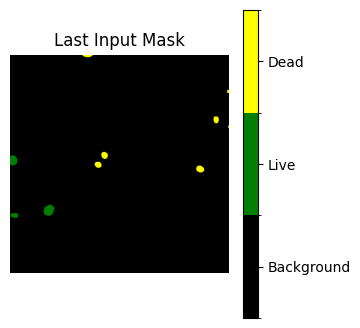

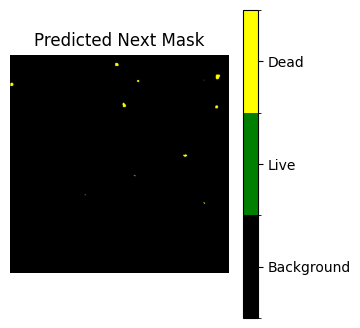

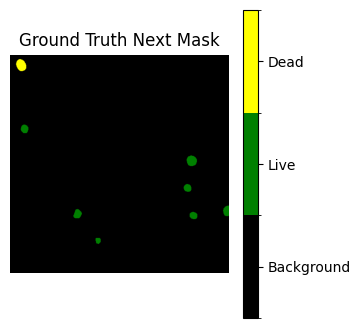

In [127]:
def reshape_and_show(index):
    input_seq = all_inputs[index].numpy().reshape(seq_length, IMG_HEIGHT, IMG_WIDTH)
    predicted_mask = all_predictions[index].numpy().reshape(IMG_HEIGHT, IMG_WIDTH)
    ground_truth_mask = all_labels[index].numpy().reshape(IMG_HEIGHT, IMG_WIDTH)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    show_mask(input_seq[-1], title="Last Input Mask")
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 2)
    show_mask(predicted_mask, title="Predicted Next Mask")
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 3)
    show_mask(ground_truth_mask, title="Ground Truth Next Mask")
    plt.show()

random_idx = random.randint(0, len(all_inputs) - 1)
reshape_and_show(random_idx)


In [128]:
def save_mask(mask, save_path, title=None):
    cmap = plt.cm.colors.ListedColormap(['black', 'green', 'yellow'])  
    bounds = [-0.5, 0.5, 1.5, 2.5]  
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    plt.figure()
    plt.imshow(mask, cmap=cmap, norm=norm)
    cbar = plt.colorbar(ticks=[0, 1, 2])
    cbar.ax.set_yticklabels(['Background', 'Live', 'Dead'])
    plt.axis('off')
    if title:
        plt.title(title)
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()


In [129]:
def reshape_and_save(index, save_dir='./saved_images'):
    import os

    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    input_seq = all_inputs[index].numpy().reshape(seq_length, IMG_HEIGHT, IMG_WIDTH)
    predicted_mask = all_predictions[index].numpy().reshape(IMG_HEIGHT, IMG_WIDTH)
    ground_truth_mask = all_labels[index].numpy().reshape(IMG_HEIGHT, IMG_WIDTH)
        
    plt.figure(figsize=(12, 4))
    
    # Last Input Mask
    plt.subplot(1, 3, 1)
    input_path = os.path.join(save_dir,f'sample_{index}_input.png')
    save_mask(input_seq[-1], input_path ,title="Last Input Mask")
    
    # Predicted Next Mask
    plt.subplot(1, 3, 2)
    pre_path = os.path.join(save_dir,f'sample_{index}_predicted.png')
    save_mask(predicted_mask,pre_path, title="Predicted Next Mask")
    
    # Ground Truth Next Mask
    plt.subplot(1, 3, 3)
    ground_path = os.path.join(save_dir,f'sample_{index}_ground_truth.png')
    save_mask(ground_truth_mask,ground_path, title="Ground Truth Next Mask")
    
    plt.tight_layout()
    

    plt.close()


In [130]:
for idx in range(len(all_inputs)):
    reshape_and_save(idx, save_dir='./movement_predictions/13')